## Analyse ABES embeddings - 16/05/2023

Mise à jour me 26/06/2023 suite à la deuxième itération de calcul des embeddings après avoir enlevé les concepts RAMEAU qui n'étaient ni des Tf, ni des Td

# Set project

## Import packages

In [53]:
# Import librairies
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from utils_metrics import *
from utils_visualization import *

In [54]:
# Suppression des FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

### Graphical parameters

In [55]:
# Parametres graphiques
%matplotlib inline
rcParams = {
    'font.size': 14,
    'font.family':'sans-serif',
    'font.sans-serif':['Liberation Sans'],
    'axes.labelsize': 14,
    'legend.fontsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.max_open_warning': 30}

sns.set(rc=rcParams)
sns.set_style(
    "whitegrid", {
        'axes.edgecolor': 'k',
        'axes.linewidth': 1,
        'axes.grid': True,
        'xtick.major.width': 1,
        'ytick.major.width': 1
        })

sns.set_context(
    "notebook",
    font_scale=1.1,
    rc={"lines.linewidth": 1.5})

pd.set_option('display.max_columns', None)

### Paths

In [56]:
# Set paths
path = "."
os.chdir(path)
data_path = path + "/data"
data_path_embed = "/home/aurelie/ABES/labo-indexation-ai/data/embeddings/juin2023"
output_path = path + "/outputs"
fig_path = path + "/figs"

# Import data

In [57]:
# Original dataset
rameau_file = "rameau_Tf_Td_withURI.csv"
test_dataset = "test_dataset.csv"
valid100_dataset = "valid100_dataset.csv"
embedding_test = "test_dataset_resu.csv"
embedding_100notices = "valid100_dataset_resu.csv"

## Check Files

In [58]:
# Import rameau list
ram = pd.read_csv(os.path.join(data_path, rameau_file))
print("Nombre de notices différentes: ", ram.shape[0])
ram.head(10)

Nombre de notices différentes:  103628


,Unnamed: 0,PPN,NOM,URI
0,0,157992527,Kirp?n,https://www.idref.fr/157992527
1,1,110140494,Militaires artistes,https://www.idref.fr/110140494
2,2,028492161,Militaires romains,https://www.idref.fr/028492161
3,3,028521757,Militaires prussiens,https://www.idref.fr/028521757
4,4,029895561,Sa-skya-pa,https://www.idref.fr/029895561
5,5,031875459,Militaires réunionnais,https://www.idref.fr/031875459
6,6,032370083,Construction à l'épreuve de la sécheresse,https://www.idref.fr/032370083
7,7,032878117,Missionnaires suisses,https://www.idref.fr/032878117
8,8,034423982,Militaires ivoiriens,https://www.idref.fr/034423982
9,9,034686940,Outils à métaux,https://www.idref.fr/034686940


In [59]:
# Import train dataset
df_train = pd.read_csv(os.path.join(data_path, "train_dataset.csv"))
df_train["PPN"] = df_train["PPN"].astype(str)
print("Dimension of the dataset: ", df_train.shape)

Dimension of the dataset:  (125264, 10)


In [60]:
# Verification de la bonne prise en compte des ";" dans les concepts
df_train[df_train['PPN'] == "187570213"]

,PPN,TITRE,RESUME,RAMEAU,DEWEY,DESCR,RAMEAU_CHECKED,presence_chaine_indexation,rameau_chaines_index,rameau_concepts
36222,187570213,Le poulet en 100 recettes,Tout le monde aime le poulet ! Irrésistible lo...,Cuisine (poulet ; viande),641.665,Le poulet en 100 recettes Tout le monde aime ...,Cuisine (poulet ; viande),False,['Cuisine (poulet ; viande)'],['Cuisine (poulet ; viande)']


In [62]:
# Verification de la bonne prise en compte des ";" dans les concepts
df_train[df_train["RAMEAU"].str.contains(" ; ")]

In [10]:
# Import test dataset
df_test = pd.read_csv(os.path.join(data_path, test_dataset))
df_test["PPN"] = df_test["PPN"].astype(str)
print("Dimension of the dataset: ", df_test.shape)
df_test.head()

Dimension of the dataset:  (29244, 10)


,PPN,TITRE,RESUME,RAMEAU,DEWEY,DESCR,RAMEAU_CHECKED,presence_chaine_indexation,rameau_chaines_index,rameau_concepts
0,00002564X,La révolution structurale,"Mutations ou crises, les brusques accès de fiè...",Structuralisme,100,"La révolution structurale Mutations ou crises,...",Structuralisme,False,['Structuralisme'],['Structuralisme']
1,000057525,La théorie des jeux et ses applications à l'éc...,La théorie des jeux occupe au sein des mathéma...,Mathématiques économiques;Théorie des jeux,519.3,La théorie des jeux et ses applications à l'éc...,Mathématiques économiques;Théorie des jeux,False,"['Mathématiques économiques', 'Théorie des jeux']","['Mathématiques économiques', 'Théorie des jeux']"
2,000079472,Pétrole : le vrai dossier,Que dissimulent les événements que nous avons ...,Crise économique (1973),320,Pétrole : le vrai dossier Que dissimulent les ...,Crise économique (1973),False,['Crise économique (1973)'],['Crise économique (1973)']
3,000085642,Magie : aspects de la tradition occidentale,La magie se situe au cœur de la tradition occu...,Magie,100,Magie : aspects de la tradition occidentale La...,Magie,False,['Magie'],['Magie']
4,000087637,Mathématiques de base pour les linguistes,La fonction essentielle de ce livre est de fai...,Linguistique -- Méthodes graphiques;Linguistiq...,510,Mathématiques de base pour les linguistes La f...,Linguistique -- Méthodes graphiques;Linguistiq...,True,"['Linguistique -- Méthodes graphiques', 'Lingu...","['Linguistique', 'Méthodes graphiques', 'Lingu..."


In [11]:
# Check import for embeddings
pattern = r';;\s*(?![^()$]*\))| -- |-- | --|--| - '
emb_test = pd.read_csv(
    os.path.join(data_path_embed, embedding_test))

emb_test.rename(columns={"ppn" : "PPN", "label": "embedding_chains"}, inplace=True)
emb_test["embeddings_autorites"] = emb_test["embedding_chains"].apply(lambda x: re.split(pattern, str(x)))
emb_test.head(20)

,PPN,score,embedding_chains,embeddings_autorites
0,00002564X,0.797401,Innovation -- Philosophie,"[Innovation, Philosophie]"
1,00002564X,0.779297,Innovation -- Aspect social,"[Innovation, Aspect social]"
2,00002564X,0.775827,Technique -- Aspect social,"[Technique, Aspect social]"
3,00002564X,0.774429,Prévision technologique,[Prévision technologique]
4,00002564X,0.773781,Technique et civilisation,[Technique et civilisation]
5,00002564X,0.770500,Philosophie de la technique,[Philosophie de la technique]
6,000057525,0.801763,Mathématiques économiques,[Mathématiques économiques]
7,000057525,0.764727,Économétrie,[Économétrie]
8,000057525,0.761931,Modèles mathématiques,[Modèles mathématiques]
9,000057525,0.759410,Modèles économétriques,[Modèles économétriques]


In [12]:
def flatten(list):
    flat_list = [item for sublist in list for item in sublist]
    return flat_list

In [13]:
keywords = flatten(emb_test["embeddings_autorites"])
chaines = emb_test["embedding_chains"].unique()
print(f"Le dataset contient: \n - {len(set(keywords))} autorités RAMEAU differentes \n - {len(chaines)} chaines d'indexation différentes")

Le dataset contient: 
 - 8468 autorités RAMEAU differentes 
 - 13543 chaines d'indexation différentes


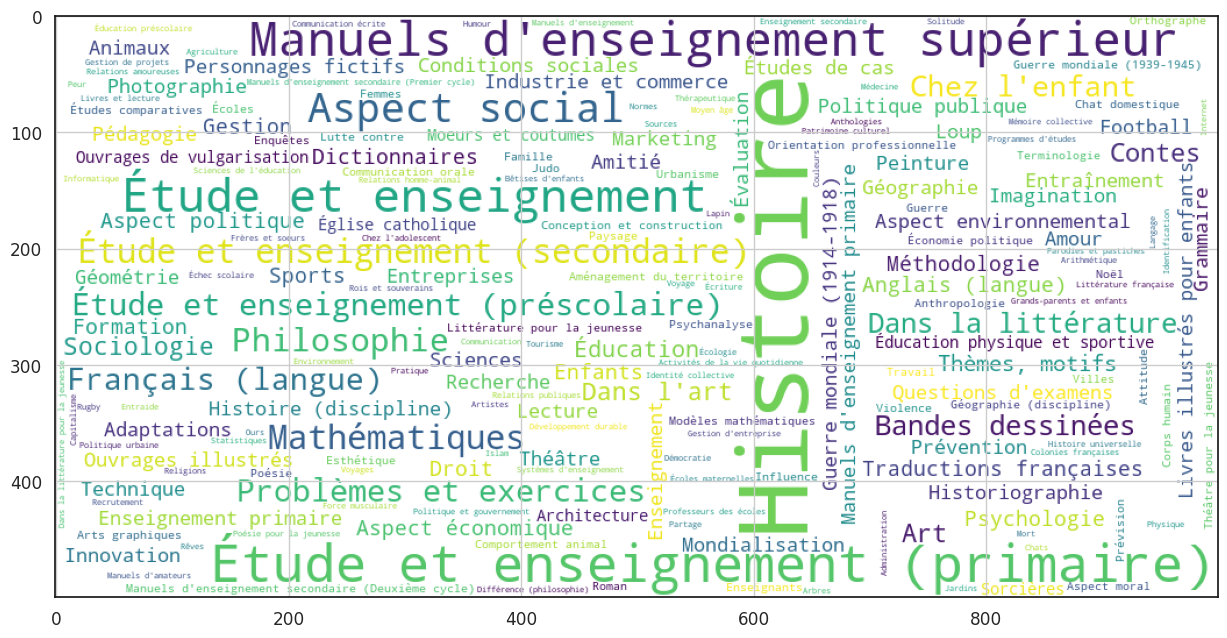

In [14]:
# Get list of labels
plot_wordcloud(
    keywords,
    backgound_color="white",
    figsize=(15, 8),
    width=1000,
    height=500,
    save_file="wordcloud_embeddings_autorites.png",
)

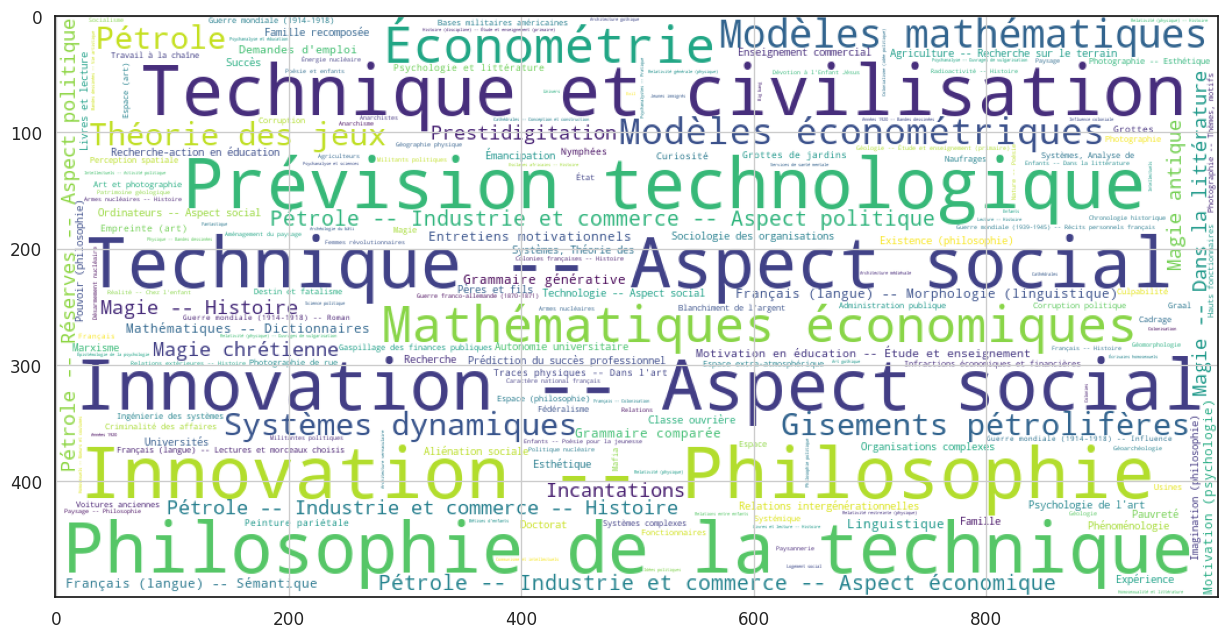

In [15]:
# Get list of chaines
plot_wordcloud(
    chaines,
    backgound_color="white",
    figsize=(15, 8),
    width=1000,
    height=500,
    save_file="wordcloud_embeddings_chaines.png",
)

In [16]:
# check that all labels belongs to rameau
# Verification que toutes les vedettes appartiennent au referenciel RAMEAU
RAMEAU = ram["NOM"].to_list()

if all([item in RAMEAU for item in keywords]):
    print("Tous les mots clés sont des concepts rameau")
else:
    check = [item in RAMEAU for item in keywords]
    bad_keywords = []
    for i in range(len(check)):
        if not check[i]:
            bad_keywords.append(keywords[i])
 
    unknown_concepts = list(set(bad_keywords))
    print(f"{len(unknown_concepts)} mots clés absents du répertoire RAMEAU sur un total de {len(set(keywords))}")
    

7 mots clés absents du répertoire RAMEAU sur un total de 8468


In [17]:
# Save list of badly formatted concepts, for check
with open(os.path.join(data_path, "concepts_a_verifier_embeddingfile_juin2023.txt"), "w") as output:
    output.write(str(unknown_concepts))
unknown_concepts

["Séparation des Églises et de l'État (France ",
 'Participation des citoyen',
 'Colonnes infernales (Guerre de Vendée ',
 ' 1793-1794)',
 'Cuisine (poulet ',
 ' 1905-1906)',
 ' viande)']

## Compute all labels for all notices

In [18]:
chains_emb_test = pd.DataFrame(emb_test.groupby("PPN")["embedding_chains"].apply(lambda x: ','.join(x).split(","))).reset_index()
chains_emb_test

,PPN,embedding_chains
0,00002564X,"[Innovation -- Philosophie, Innovation -- Aspe..."
1,000057525,"[Mathématiques économiques, Économétrie, Modèl..."
2,000079472,"[Pétrole, Gisements pétrolifères, Pétrole -- I..."
3,000085642,"[Magie -- Histoire, Magie chrétienne, Magie an..."
4,000087637,[Français (langue) -- Morphologie (linguistiqu...
...,...,...
6234,169836118,"[Blanchiment de l'argent -- Lutte contre, Blan..."
6235,169840700,"[Chinois (langue), Écriture chinoise, Chinois ..."
6236,169843912,"[Régionalisme, Européanisme, Nationalisme, Féd..."
6237,169849252,"[Peur -- Contes, Ours en peluche, Peur, Suspen..."


In [19]:
chains_emb_test["embeddings_autorites"] = chains_emb_test["embedding_chains"].apply(lambda x: flatten([y.split(' -- ') for y in x]))
chains_emb_test

,PPN,embedding_chains,embeddings_autorites
0,00002564X,"[Innovation -- Philosophie, Innovation -- Aspe...","[Innovation, Philosophie, Innovation, Aspect s..."
1,000057525,"[Mathématiques économiques, Économétrie, Modèl...","[Mathématiques économiques, Économétrie, Modèl..."
2,000079472,"[Pétrole, Gisements pétrolifères, Pétrole -- I...","[Pétrole, Gisements pétrolifères, Pétrole, Ind..."
3,000085642,"[Magie -- Histoire, Magie chrétienne, Magie an...","[Magie, Histoire, Magie chrétienne, Magie anti..."
4,000087637,[Français (langue) -- Morphologie (linguistiqu...,"[Français (langue), Morphologie (linguistique)..."
...,...,...,...
6234,169836118,"[Blanchiment de l'argent -- Lutte contre, Blan...","[Blanchiment de l'argent, Lutte contre, Blanch..."
6235,169840700,"[Chinois (langue), Écriture chinoise, Chinois ...","[Chinois (langue), Écriture chinoise, Chinois ..."
6236,169843912,"[Régionalisme, Européanisme, Nationalisme, Féd...","[Régionalisme, Européanisme, Nationalisme, Féd..."
6237,169849252,"[Peur -- Contes, Ours en peluche, Peur, Suspen...","[Peur, Contes, Ours en peluche, Peur, Suspense..."


In [20]:
flatten(chains_emb_test["embedding_chains"])

['Innovation -- Philosophie',
 'Innovation -- Aspect social',
 'Technique -- Aspect social',
 'Prévision technologique',
 'Technique et civilisation',
 'Philosophie de la technique',
 'Mathématiques économiques',
 'Économétrie',
 'Modèles mathématiques',
 'Modèles économétriques',
 'Systèmes dynamiques',
 'Théorie des jeux',
 'Pétrole',
 'Gisements pétrolifères',
 'Pétrole -- Industrie et commerce -- Aspect politique',
 'Pétrole -- Industrie et commerce -- Aspect économique',
 'Pétrole -- Industrie et commerce -- Histoire',
 'Pétrole -- Réserves -- Aspect politique',
 'Magie -- Histoire',
 'Magie chrétienne',
 'Magie antique',
 'Prestidigitation',
 'Incantations',
 'Magie -- Dans la littérature',
 'Français (langue) -- Morphologie (linguistique)',
 'Linguistique',
 'Français (langue) -- Sémantique',
 'Grammaire générative',
 'Mathématiques -- Dictionnaires',
 'Grammaire comparée',
 'Motivation (psychologie)',
 'Entretiens motivationnels',
 'Motivation en éducation -- Étude et enseignem

## Export data

In [21]:
# save to csv
chains_emb_test.to_csv(os.path.join(data_path_embed, "embeddings_results_test.csv"))

## Same process for valid test

Le dataset contient: 
 - 557 autorités RAMEAU differentes 
 - 578 chaines d'indexation différentes
2 mots clés absents du répertoire RAMEAU sur un total de 557
Concepts inconnus du répertoire RAMEAU :
 ['Technique', 'Industrie']


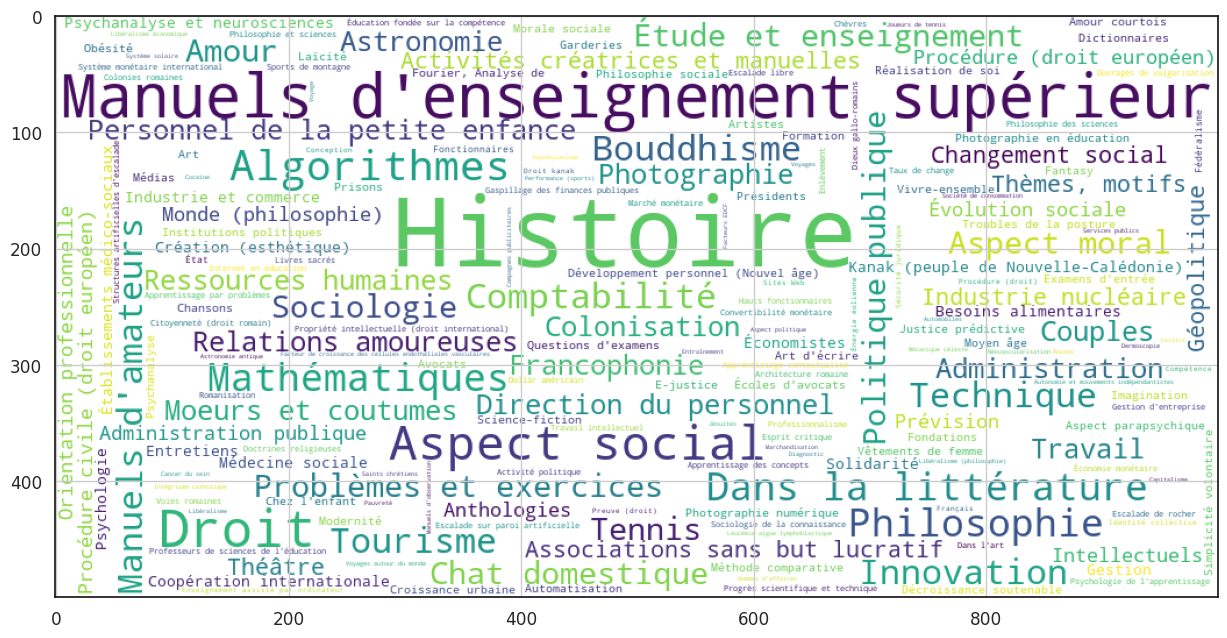

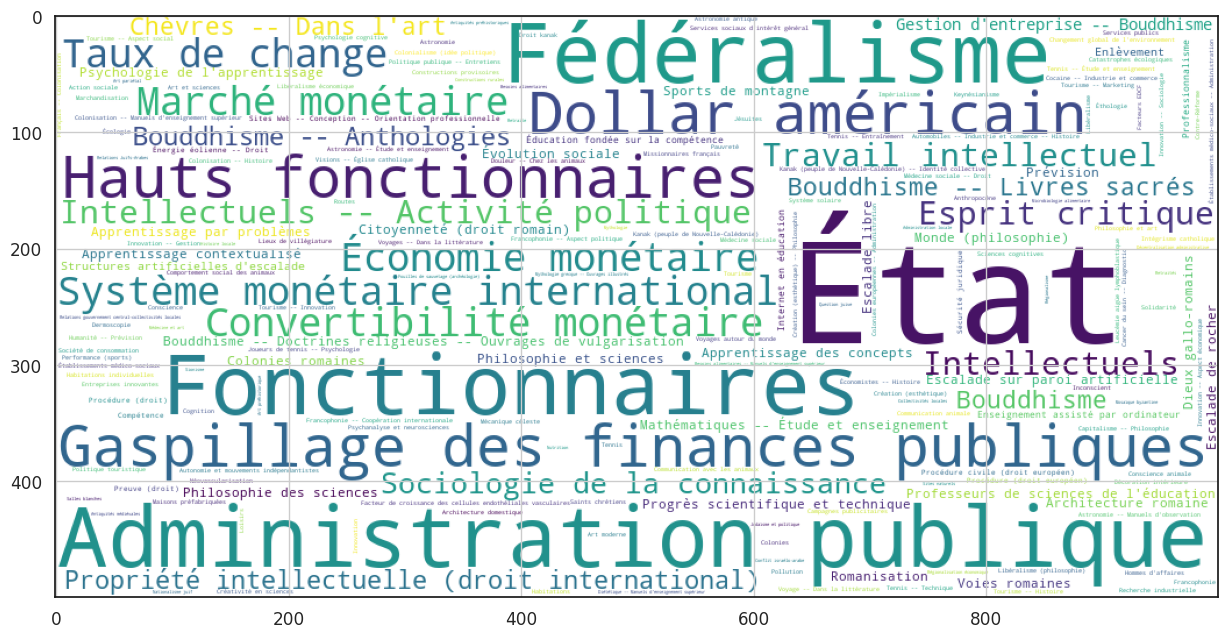

In [22]:
# Check import for embeddings
emb_valid = pd.read_csv(
    os.path.join(data_path_embed, embedding_100notices))
emb_valid.rename(columns={"ppn" : "PPN", "label": "embedding_chains"}, inplace=True)
emb_valid["embeddings_autorites"] = emb_valid["embedding_chains"].apply(lambda x: re.split(pattern, str(x)))
keywords_valid = flatten(emb_valid["embeddings_autorites"])
chaines_valid = emb_valid["embedding_chains"].unique()
print(f"Le dataset contient: \n - {len(set(keywords_valid))} autorités RAMEAU differentes \n - {len(chaines_valid)} chaines d'indexation différentes")

# Get list of labels
plot_wordcloud(
    keywords_valid,
    backgound_color="white",
    figsize=(15, 8),
    width=1000,
    height=500,
    save_file="wordcloud_embeddings_autorites_validation_dataset.png",
)
# Get list of chaines
plot_wordcloud(
    chaines_valid,
    backgound_color="white",
    figsize=(15, 8),
    width=1000,
    height=500,
    save_file="wordcloud_embeddings_chaines_validation_dataset.png",
)

# Verification que toutes les vedettes appartiennent au referenciel RAMEAU
if all([item in RAMEAU for item in keywords_valid]):
    print("Tous les mots clés sont des concepts rameau")
else:
    check = [item in RAMEAU for item in keywords_valid]
    bad_keywords_valid = []
    for i in range(len(check)):
        if not check[i]:
            bad_keywords_valid.append(keywords[i])
 
    unknown_concepts_valid = list(set(bad_keywords_valid))
    print(f"{len(unknown_concepts_valid)} mots clés absents du répertoire RAMEAU sur un total de {len(set(keywords_valid))}")
    
# Save list of badly formatted concepts, for check
with open(os.path.join(data_path, "concepts_a_verifier_embeddingfile_valid100_juin2023.txt"), "w") as output:
    output.write(str(unknown_concepts_valid))
print("Concepts inconnus du répertoire RAMEAU :\n", unknown_concepts_valid)

chains_emb_valid = pd.DataFrame(emb_valid.groupby("PPN")["embedding_chains"].apply(lambda x: ','.join(x).split(","))).reset_index()
chains_emb_valid["embeddings_autorites"] = chains_emb_valid["embedding_chains"].apply(lambda x: flatten([y.split(' -- ') for y in x]))

# save to csv
chains_emb_valid.to_csv(os.path.join(data_path_embed, "embeddings_results_valid100.csv"))

## Merge Sudoc et embeddings

In [23]:
# Check notices extraction 
df = df_test.merge(emb_test, on="PPN", how="inner")
print("Dimension after merge: ", df.shape)
df.head()

Dimension after merge:  (37432, 13)


,PPN,TITRE,RESUME,RAMEAU,DEWEY,DESCR,RAMEAU_CHECKED,presence_chaine_indexation,rameau_chaines_index,rameau_concepts,score,embedding_chains,embeddings_autorites
0,00002564X,La révolution structurale,"Mutations ou crises, les brusques accès de fiè...",Structuralisme,100,"La révolution structurale Mutations ou crises,...",Structuralisme,False,['Structuralisme'],['Structuralisme'],0.797401,Innovation -- Philosophie,"[Innovation, Philosophie]"
1,00002564X,La révolution structurale,"Mutations ou crises, les brusques accès de fiè...",Structuralisme,100,"La révolution structurale Mutations ou crises,...",Structuralisme,False,['Structuralisme'],['Structuralisme'],0.779297,Innovation -- Aspect social,"[Innovation, Aspect social]"
2,00002564X,La révolution structurale,"Mutations ou crises, les brusques accès de fiè...",Structuralisme,100,"La révolution structurale Mutations ou crises,...",Structuralisme,False,['Structuralisme'],['Structuralisme'],0.775827,Technique -- Aspect social,"[Technique, Aspect social]"
3,00002564X,La révolution structurale,"Mutations ou crises, les brusques accès de fiè...",Structuralisme,100,"La révolution structurale Mutations ou crises,...",Structuralisme,False,['Structuralisme'],['Structuralisme'],0.774429,Prévision technologique,[Prévision technologique]
4,00002564X,La révolution structurale,"Mutations ou crises, les brusques accès de fiè...",Structuralisme,100,"La révolution structurale Mutations ou crises,...",Structuralisme,False,['Structuralisme'],['Structuralisme'],0.773781,Technique et civilisation,[Technique et civilisation]


In [24]:
all_index_chain = flatten(df["rameau_chaines_index"]+ .df["embedding_chains"]to_list())
print(f"Le dataset contient:\n - {len(set(all_index_chain))} chaines d'indexation différentes")

Le dataset contient:
 - 92 chaines d'indexation différentes


In [25]:
df.to_csv(os.path.join(data_path,"merge_embeddings.csv"))

['[',
 "'",
 'S',
 't',
 'r',
 'u',
 'c',
 't',
 'u',
 'r',
 'a',
 'l',
 'i',
 's',
 'm',
 'e',
 "'",
 ']',
 '[',
 "'",
 'S',
 't',
 'r',
 'u',
 'c',
 't',
 'u',
 'r',
 'a',
 'l',
 'i',
 's',
 'm',
 'e',
 "'",
 ']',
 '[',
 "'",
 'S',
 't',
 'r',
 'u',
 'c',
 't',
 'u',
 'r',
 'a',
 'l',
 'i',
 's',
 'm',
 'e',
 "'",
 ']',
 '[',
 "'",
 'S',
 't',
 'r',
 'u',
 'c',
 't',
 'u',
 'r',
 'a',
 'l',
 'i',
 's',
 'm',
 'e',
 "'",
 ']',
 '[',
 "'",
 'S',
 't',
 'r',
 'u',
 'c',
 't',
 'u',
 'r',
 'a',
 'l',
 'i',
 's',
 'm',
 'e',
 "'",
 ']',
 '[',
 "'",
 'S',
 't',
 'r',
 'u',
 'c',
 't',
 'u',
 'r',
 'a',
 'l',
 'i',
 's',
 'm',
 'e',
 "'",
 ']',
 '[',
 "'",
 'M',
 'a',
 't',
 'h',
 'é',
 'm',
 'a',
 't',
 'i',
 'q',
 'u',
 'e',
 's',
 ' ',
 'é',
 'c',
 'o',
 'n',
 'o',
 'm',
 'i',
 'q',
 'u',
 'e',
 's',
 "'",
 ',',
 ' ',
 "'",
 'T',
 'h',
 'é',
 'o',
 'r',
 'i',
 'e',
 ' ',
 'd',
 'e',
 's',
 ' ',
 'j',
 'e',
 'u',
 'x',
 "'",
 ']',
 '[',
 "'",
 'M',
 'a',
 't',
 'h',
 'é',
 'm',
 'a',
 't'

In [37]:
df["rameau_concept"].append(df["embedding_chains"].to_list())

AttributeError: 'Series' object has no attribute 'append'

## Multilabel classification - Metrics

In [26]:
from sklearn.preprocessing import MultiLabelBinarizer


In [27]:
# Variables to use
## Chains
field = [
    ("Chaines indexation", all_index_chain, "rameau_chaines_index", "embedding_chains"),
    ("Autorités", ram["NOM"], "rameau_concepts", "embeddings_autorites")
]
results = dict()


In [30]:
[all_index_chain]

[['[',
  "'",
  'S',
  't',
  'r',
  'u',
  'c',
  't',
  'u',
  'r',
  'a',
  'l',
  'i',
  's',
  'm',
  'e',
  "'",
  ']',
  'I',
  'n',
  'n',
  'o',
  'v',
  'a',
  't',
  'i',
  'o',
  'n',
  ' ',
  '-',
  '-',
  ' ',
  'P',
  'h',
  'i',
  'l',
  'o',
  's',
  'o',
  'p',
  'h',
  'i',
  'e',
  '[',
  "'",
  'S',
  't',
  'r',
  'u',
  'c',
  't',
  'u',
  'r',
  'a',
  'l',
  'i',
  's',
  'm',
  'e',
  "'",
  ']',
  'I',
  'n',
  'n',
  'o',
  'v',
  'a',
  't',
  'i',
  'o',
  'n',
  ' ',
  '-',
  '-',
  ' ',
  'A',
  's',
  'p',
  'e',
  'c',
  't',
  ' ',
  's',
  'o',
  'c',
  'i',
  'a',
  'l',
  '[',
  "'",
  'S',
  't',
  'r',
  'u',
  'c',
  't',
  'u',
  'r',
  'a',
  'l',
  'i',
  's',
  'm',
  'e',
  "'",
  ']',
  'T',
  'e',
  'c',
  'h',
  'n',
  'i',
  'q',
  'u',
  'e',
  ' ',
  '-',
  '-',
  ' ',
  'A',
  's',
  'p',
  'e',
  'c',
  't',
  ' ',
  's',
  'o',
  'c',
  'i',
  'a',
  'l',
  '[',
  "'",
  'S',
  't',
  'r',
  'u',
  'c',
  't',
  'u',
  'r',
  'a',

In [ ]:
mlb = MultiLabelBinarizer(sparse_output=False)
mlb.fit([all_index_chain])

In [86]:
# Binarization
for var in field: 
    print("Working on ", var[0])
    mlb = MultiLabelBinarizer(sparse_output=False)
    mlb.fit([var[1]])
    sudoc = mlb.transform(df[var[2]])
    embed = mlb.transform(df[var[3]])
    results[str("Embeddings_" + var[0])] = label_metrics_report("Embeddings", sudoc, embed, zero_division=0)

Working on  Chaines indexation
Working on  Autorités


/home/aurelie/anaconda3/envs/abes_index/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) [' ', '"', '#', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ';', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'À', 'Â', 'É', 'Î', 'à', 'â', 'ç', 'è', 'é', 'ê', 'ë', 'î', 'ï', 'ô', 'ö', 'û', 'ü'] will be ignored
  warnings.warn(
/home/aurelie/anaconda3/envs/abes_index/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) [' 1793-1794)', ' 1905-1906)', ' viande)', 'Colonnes infernales (Guerre de Vendée ', 'Cuisine (poulet ', 'Participation des citoyen', "Séparation des Églises et de l'État (France "] will be ignored
  warnings.warn(


KeyboardInterrupt: 

In [26]:
mlb.inverse_transform(embed)

[('Administration',
  'Administration publique',
  'Fonction publique',
  'Fonctionnaires',
  'Fédéralisme',
  'État'),
 ('Convertibilité monétaire',
  'Dollar américain',
  'Marché monétaire',
  'Système monétaire international',
  'Taux de change',
  'Économie monétaire'),
 ('Activité politique',
  'Esprit critique',
  'Intellectuels',
  'Propriété intellectuelle (droit européen)',
  'Sociologie de la connaissance',
  'Travail intellectuel'),
 ('Anthologies',
  'Aspect religieux',
  'Bouddhisme',
  'Dessin',
  'Doctrines religieuses',
  "Gestion d'entreprise",
  'Livres sacrés',
  'Ouvrages de vulgarisation'),
 ('Apprentissage des concepts',
  'Apprentissage par problèmes',
  "Chez l'adolescent",
  'Enseignement',
  'Pratique',
  "Psychologie de l'apprentissage",
  "Qualité de l'enseignement",
  'Raisonnement'),
 ('Monde (philosophie)',
  'Philosophie des sciences',
  'Philosophie et sciences',
  'Progrès scientifique et technique',
  'Prévision',
  'Évolution sociale'),
 ('Architect

### Dataframe of results

In [27]:
result_df = pd.DataFrame(results).T
result_df

,Hamming Loss,Brier Loss,Accuracy,Precision - Macro,Recall - Macro,F1_Score - Macro,Jaccard - Macro,Precision - Sample,Recall - Sample,F1_Score - Sample,Jaccard - Sample,Precision,Recall,F1-measure,Jaccard
Embeddings_Chaines indexation,0.009777,NaN,0.0,0.092179,0.093575,0.092179,0.090782,0.115,0.339524,0.15893,0.098346,"{'Macro': 0.09217877094972067, 'Micro': 0.1142...","{'Macro': 0.0935754189944134, 'Micro': 0.29487...","{'Macro': 0.09217877094972067, 'Micro': 0.1646...","{'Macro': 0.09078212290502793, 'Micro': 0.0897..."
Embeddings_Autorités,0.011038,NaN,0.0,0.130312,0.142965,0.131054,0.123264,0.160989,0.465274,0.221226,0.138919,"{'Macro': 0.13031205464641996, 'Micro': 0.1604...","{'Macro': 0.14296455424274976, 'Micro': 0.3898...","{'Macro': 0.13105393353513656, 'Micro': 0.2273...","{'Macro': 0.12326411266260891, 'Micro': 0.1282..."


### Plot

In [28]:
# Plot results
metrics_radar_plot(
    result_df,
    remove_identity=True,
    title="Quantitative comparisons, Scaled",
    savefig="metrics_embeddings-sudoc.html",)

IndexError: list index out of range